# Positional Encoding

torch.Size([96, 4])


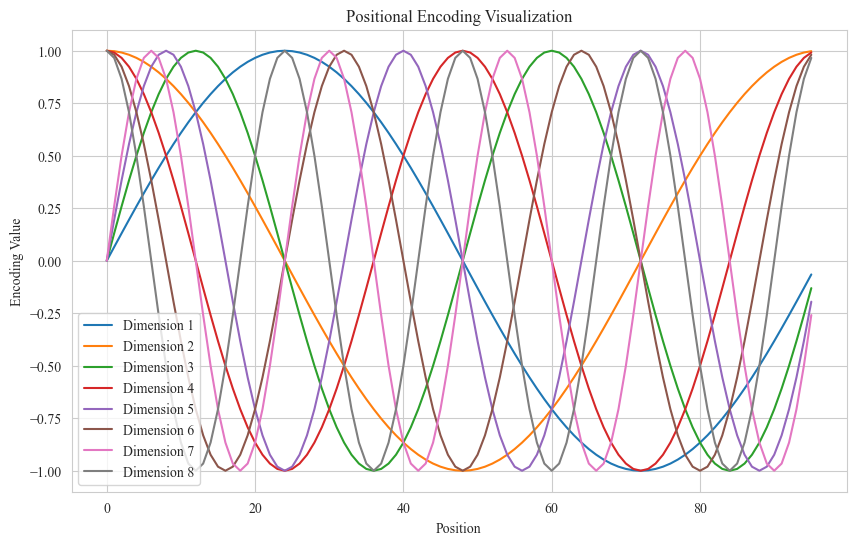

In [13]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=96):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        freq_term = torch.arange(hidden_dim//2)+1
        print(torch.sin((2/max_len)*torch.pi*position * freq_term).shape)
        
        pe[:, 0::2] = torch.sin((2/max_len)*torch.pi*position * freq_term)
        pe[:, 1::2] = torch.cos((2/max_len)*torch.pi*position * freq_term)[:, :pe[:, 1::2].shape[1]]

        self.pe = pe.unsqueeze(0)  # Shape: (1, max_len, input_dim)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)  # Ensure correct shape & device

# Initialize Positional Encoding
input_dim = 8
max_len = 96
pos_encoding = PositionalEncoding(input_dim, max_len)

# Extract Positional Encoding values
pe = pos_encoding.pe.squeeze(0)  # Remove batch dimension, shape: (max_len, input_dim)

# Plot each dimension of positional encoding
plt.figure(figsize=(10, 6))
for i in range(input_dim):
    plt.plot(pe[:, i].cpu().numpy(), label=f'Dimension {i+1}')

plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.title("Positional Encoding Visualization")
plt.legend()
plt.show()

torch.Size([96, 4])


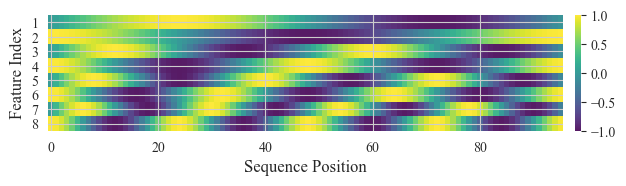

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'

# Initialize Positional Encoding
input_dim = 8
max_len = 96
pos_encoding = PositionalEncoding(input_dim, max_len)

# Extract Positional Encoding values
pe = pos_encoding.pe.squeeze(0).cpu().numpy().T  # Shape: (96, 3)

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 1.5))
im = ax.imshow(pe, aspect='auto', cmap='viridis', alpha=0.9)  # 'viridis' colormap for better contrast

# Remove axis labels, ticks, and borders
ax.set_xticks(np.arange(pe.shape[1], step=20))
ax.set_yticks(np.arange(pe.shape[0], step=1))
ax.set_yticklabels(np.arange(1, pe.shape[0]+1, step=1)) 
ax.set_frame_on(False)  # Remove frame
# ax.invert_yaxis()

# Add colorbar without border
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.outline.set_visible(False)  # Remove colorbar border
cbar.ax.set_frame_on(False)  # Hide colorbar frame
plt.xlabel("Sequence Position", size=12)
plt.ylabel("Feature Index", size=12)
plt.savefig('plots/pe.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


# Dataset

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style('whitegrid')

grid_df = pd.read_csv('./data/grid_data.csv')
grid_df = grid_df.fillna(0)

class GridTimeSeriesDataset:
    def __init__(self, dataframe, scale=False):

        self.dataframe = dataframe
        self.days = np.sort(self.dataframe['day'].unique())  # Unique sorted days
        self.train, self.test = train_test_split(self.days, test_size=0.1, random_state=42)

        self.scale = scale
        if self.scale: self.load_samples()

        # Compute min and max values for normalization
        self.min = dataframe.min()
        self.max = dataframe.max()

    def __len__(self):
        return len(self.days)

    def __getitem__(self, index):
        if index >= len(self.days):
            raise IndexError("Index out of range")

        day = self.days[index]
        day_data = self.dataframe[self.dataframe['day'] == day].copy()
        
        if self.scale:
            day_data['solar (MW)'] = self.min_max_scale(day_data['solar (MW)'], ts_type='solar')
            day_data['wind (MW)'] = self.min_max_scale(day_data['wind (MW)'], ts_type='wind')
            day_data['load (MW)'] = self.min_max_scale(day_data['load (MW)'], ts_type='load')
            day_data['price (EUR/MWh)'] = self.min_max_scale(day_data['price (EUR/MWh)'], ts_type='price')
            day_data['emission factor (kg CO2/MWh)'] = self.min_max_scale(day_data['emission factor (kg CO2/MWh)'], ts_type='co2')
            # day_data['solar (MW)'] = self.scale_feature(day_data['solar (MW)'], ts_type='solar')
            # day_data['solar (MW)'] = self.remove_bias(day_data['solar (MW)'])
            # day_data['wind (MW)'] =  self.scale_feature(day_data['wind (MW)'], ts_type='wind')
            # day_data['load (MW)'] =  self.scale_feature(day_data['load (MW)'], ts_type='load')


        return {
            'time': np.arange(len(day_data)),  # Time indices
            'solar': day_data['solar (MW)'].to_numpy(dtype=np.float32),
            'wind': day_data['wind (MW)'].to_numpy(dtype=np.float32),
            'load': day_data['load (MW)'].to_numpy(dtype=np.float32),
            'solar_forecast': day_data['solar_forcast (MW)'].to_numpy(dtype=np.float32),
            'wind_forecast': day_data['wind_forecast (MW)'].to_numpy(dtype=np.float32),
            'load_forecast': day_data['load_forecast (MW)'].to_numpy(dtype=np.float32),
            'price': day_data['price (EUR/MWh)'].to_numpy(dtype=np.float32),
            'emission_factor': day_data['emission factor (kg CO2/MWh)'].to_numpy(dtype=np.float32),
        }
    
    def load_samples(self):
        # Load sample time series (to scale to the sample data)
        sample_solar = np.repeat(np.load('./data/sample/pv.npy'), 4)
        sample_wind = np.repeat(np.load('./data/sample/wt.npy'), 4)
        sample_load = np.repeat(np.load('./data/sample/load.npy'), 4)
        sample_price = np.repeat(np.load('./data/sample/price.npy'), 4)
        sample_co2 = np.repeat(np.load('./data/sample/co2.npy'), 4)/1000

        # Compute the mean and std of the sample time series
        self.mean_solar = np.mean(sample_solar)
        self.std_solar = np.std(sample_solar)
        self.min_solar = np.min(sample_solar)
        self.max_solar = np.max(sample_solar)

        self.mean_wind = np.mean(sample_wind)
        self.std_wind = np.std(sample_wind)
        self.min_wind = np.min(sample_wind)
        self.max_wind = np.max(sample_wind)

        self.mean_load = np.mean(sample_load)
        self.std_load = np.std(sample_load)
        self.min_load = np.min(sample_load)
        self.max_load = np.max(sample_load)

        self.mean_price = np.mean(sample_price)
        self.std_price = np.std(sample_price)
        self.min_price = np.min(sample_price)
        self.max_price = np.max(sample_price)

        self.mean_co2 = np.mean(sample_co2)
        self.std_co2 = np.std(sample_co2)
        self.min_co2 = np.min(sample_co2)
        self.max_co2 = np.max(sample_co2)

    # Apply Z-score standardization and rescale to sample's mean and std
    def scale_feature(self, data, ts_type):
        if ts_type == 'solar': mean_sample, std_sample = self.mean_solar, self.std_solar
        elif ts_type == 'wind': mean_sample, std_sample = self.mean_wind, self.std_wind
        elif ts_type == 'load': mean_sample, std_sample = self.mean_load, self.std_load

        feature_mean = np.mean(data)
        feature_std = np.std(data)
        return (data - feature_mean) / feature_std * std_sample + mean_sample

    def remove_bias(self, data):
        return data - np.min(data)
    
    def min_max_scale(self, data, ts_type):
        if ts_type == 'solar': min_sample, max_sample = self.min_solar, self.max_solar
        elif ts_type == 'wind': min_sample, max_sample = self.min_wind, self.max_wind
        elif ts_type == 'load': min_sample, max_sample = self.min_load, self.max_load
        elif ts_type == 'price': min_sample, max_sample = self.min_price, self.max_price
        elif ts_type == 'co2': min_sample, max_sample = self.min_co2, self.max_co2
        min_data = np.min(data)
        max_data = np.max(data)
        return (data - min_data) / (max_data - min_data) * (max_sample - min_sample) + min_sample


# Example Usage:
dataset = GridTimeSeriesDataset(grid_df, scale=True)
sample = dataset[42]

Text(0, 0.5, 'State of Charge (%)')

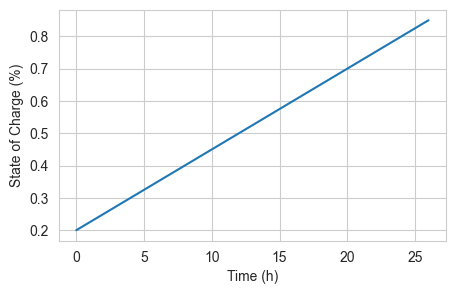

In [16]:
class storage:
    def __init__(self, SOC, dt):
        # Parameters
        self.eta_charge = 1
        self.eta_discharge = 1
        self.Capacity = 40 # kWh
        # Constraints
        self.Pbatt_max = 4 # kW
        self.SOC_min = 0.2
        self.SOC_max = 0.85
        # Variables
        self.SOC = np.clip(SOC, self.SOC_min, self.SOC_max)
        self.dt = dt

    def update(self, Pbatt):
        self.SOC += (self.eta_charge/self.Capacity)*np.maximum(0, Pbatt)*self.dt +\
                    (1/self.eta_discharge/self.Capacity)*min(0, Pbatt)*self.dt
        return self.SOC

test_battery = storage(SOC=0.2, dt=1)
SOC_PLOT = [test_battery.SOC]

while test_battery.SOC<test_battery.SOC_max:
    Pbatt = 1
    test_battery.update(Pbatt)

    SOC_PLOT.append(test_battery.SOC)

plt.figure(figsize=(5,3))
plt.plot(SOC_PLOT)
plt.grid(True)
plt.xlabel('Time (h)')
plt.ylabel('State of Charge (%)')

In [17]:
#  Define the dictionary
DG_coeffs = {
    "MT": {
        "Pmin": 6,  # kW
        "Pmax": 30, # kW
        "b" : 4.37, # €/kWh
        "c": 85.06, # €/h
        "ef": 724.6/1000,# kg/kWh
        "Type": "Microturbine"
    },
    "FC": {
        "Pmin": 3,   # kW
        "Pmax": 30,  # kW
        "b": 2.84,   # €/kWh
        "c": 255.18, # €/h
        "ef": 489.4/1000, # kg/kWh
        "Type": "FC"
    },
    "WT": {
        "Pmin": 0,  # kW
        "Pmax": 15, # kW
        "b": 10.63, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Wind Turbine"
    },
    "PV1": {
        "Pmin": 0,  # kW
        "Pmax": 3,  # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 1"
    },
    "PV2": {
        "Pmin": 0 , # kW
        "Pmax": 10, # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 2"
    }
}

# Print the dictionary
pprint(DG_coeffs)

{'FC': {'Pmax': 30,
        'Pmin': 3,
        'Type': 'FC',
        'b': 2.84,
        'c': 255.18,
        'ef': 0.4894},
 'MT': {'Pmax': 30,
        'Pmin': 6,
        'Type': 'Microturbine',
        'b': 4.37,
        'c': 85.06,
        'ef': 0.7246},
 'PV1': {'Pmax': 3,
         'Pmin': 0,
         'Type': 'Photovoltaic 1',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'PV2': {'Pmax': 10,
         'Pmin': 0,
         'Type': 'Photovoltaic 2',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'WT': {'Pmax': 15,
        'Pmin': 0,
        'Type': 'Wind Turbine',
        'b': 10.63,
        'c': 0,
        'ef': 0}}


In [18]:
# Function to add Gaussian noise with varying intensity and proportional to power
def add_uncertainty(time_series, start_time, base_noise_std):
    time_steps = np.linspace(0, len(time_series), len(time_series))
    noisy_series = time_series.copy()
    start_index = np.searchsorted(time_steps, start_time)+1
    total_horizon = len(time_series) - start_index

    # Define the Gaussian uncertainty function
    for i in range(start_index, len(time_series)):
        time_distance = (i - start_index) / total_horizon  # Normalize distance to [0, 1]
        # Gaussian function for uncertainty, centered at the midpoint of the horizon
        uncertainty_scale = np.exp(-0.5 * ((time_distance - 1) ** 2) / (0.7 ** 2))  # Narrow Gaussian
        noise_scale = base_noise_std * uncertainty_scale  # Scale noise by the Gaussian function
        noise = np.random.normal(0, noise_scale) * noisy_series[i]
        noisy_series[i] += noise

    noisy_series[start_index:] = np.clip(noisy_series[start_index:], 0, None)  # Ensure no negative power
    return noisy_series

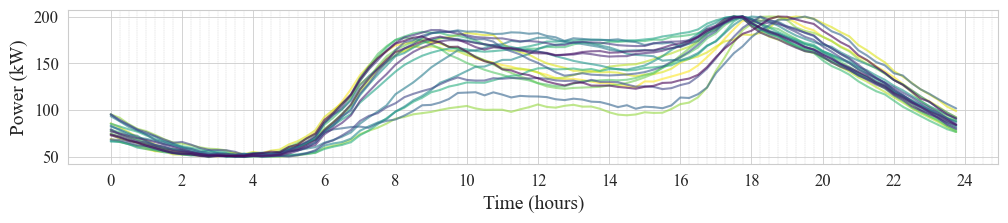

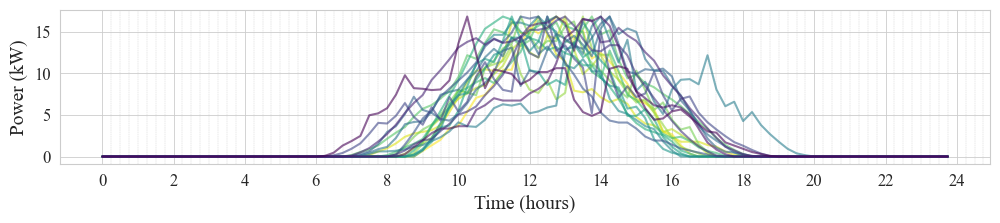

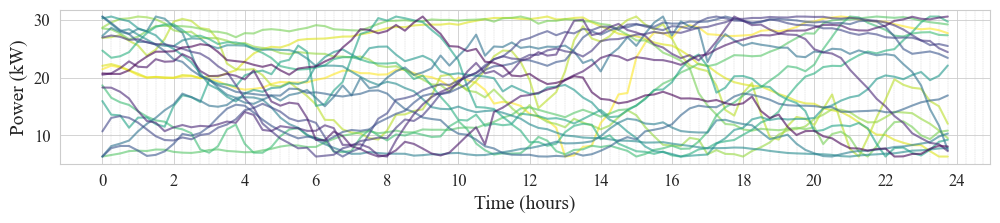

In [19]:
plt.rcParams['font.family'] = 'Times New Roman'

day_data = dataset[1]

# Define number of samples to select
num_samples = 20  

# Define types to plot
types = ['load', 'solar', 'wind']

# Get the viridis_r colormap
cmap = plt.get_cmap('viridis_r')
colors = cmap(np.linspace(0, 1, num_samples))  # Generate colors for samples

# Plot
for t in types:
    plt.figure(figsize=(12, 2))
    time_steps = np.arange(96) / 4  # Scale the time steps to hours
    
    # Get random indices for sampling
    total_days = len(day_data[t])
    random_indices = np.random.choice(total_days, num_samples, replace=False)
    
    # Plot random samples
    for i, idx in enumerate(random_indices):
        plt.plot(time_steps, dataset[idx][t], alpha=0.6, color=colors[i], 
                label=f'Sample {i+1}')
    
    # plt.legend(fontsize=10)
    plt.xlabel('Time (hours)', size=14)
    plt.ylabel('Power (kW)', size=14)
    plt.grid(True, which='minor', linestyle='--', linewidth=0.3)
    plt.grid(True, which='major', linestyle='-', linewidth=0.6)

    # Set x-axis ticks
    minor_hours = np.arange(0, 25, 0.25)
    major_hours = np.arange(0, 25, 2)
    plt.xticks(minor_hours, minor=True, fontsize=4)
    plt.xticks(major_hours, minor=False, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'plots/samples_{t}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

# Uncertainty

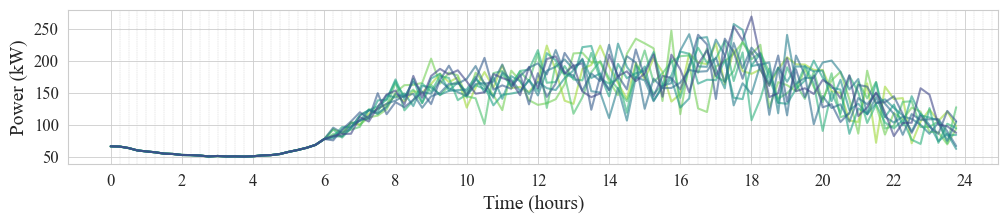

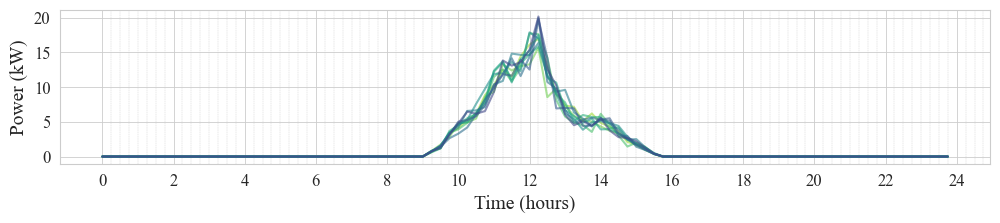

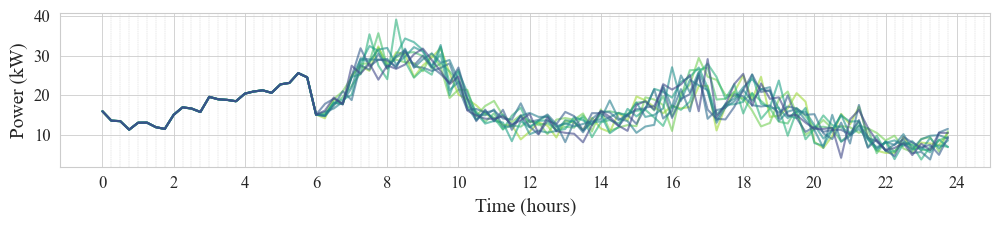

In [20]:
plt.rcParams['font.family'] = 'Times New Roman'

day_data = dataset[1]

# Define number of variations per type
num_variations = 10  

# Define types to plot
types = ['load', 'solar', 'wind']

# Get the viridis_r colormap
cmap = plt.get_cmap('viridis_r')
colors = cmap(np.linspace(0, 1, 15))  # Generate 10 colors from the colormap
# Plot

for t in types:
    plt.figure(figsize=(12, 2))
    time_steps = np.arange(96) / 4  # Scale the time steps to hours
    for i in range(num_variations):
        plt.plot(time_steps, add_uncertainty(day_data[t], 96 / 4, base_noise_std=0.2), alpha=0.6, color=colors[i+2])
    
    # plt.legend()
    # plt.title("10 Variations per Type with Added Uncertainty")
    plt.xlabel('Time (hours)', size=14)
    plt.ylabel('Power (kW)', size=14)
    plt.grid(True, which='minor', linestyle='--', linewidth=0.3)
    plt.grid(True, which='major', linestyle='-', linewidth=0.6)

    # Set x-axis ticks
    minor_hours = np.arange(0, 25, 0.25)
    major_hours = np.arange(0, 25, 2)
    plt.xticks(minor_hours, minor=True, fontsize=4)
    plt.xticks(major_hours, minor=False, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'plots/forecast_{t}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()


# Embeddings

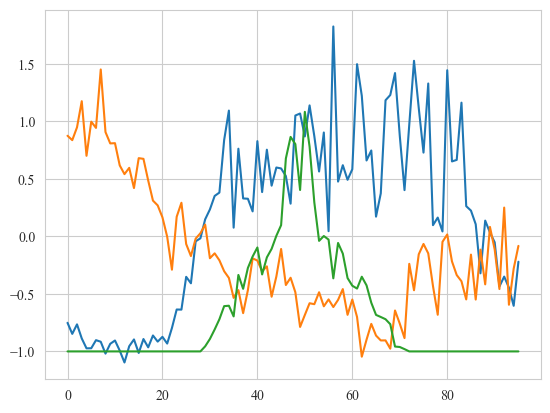

In [21]:
import gymnasium as gym
import numpy as np

class MicroGridTemporalEnv(gym.Env):
    def __init__(self, grid_df, DG_coeffs):
        super(MicroGridTemporalEnv, self).__init__()
        
        self.day = 0  # Start at the first day
        self.t = 0
        self.dt = 0.25  # Time step (hours)
        self.MAX_STEP = 24 * (1 / self.dt)  # Number of time steps in a day

        self.timeseries = GridTimeSeriesDataset(grid_df, scale=True)
        self.DG_coeffs = DG_coeffs
        self.battery = storage(SOC=0.5, dt=self.dt)

        self.PGmax = 200
        self.PBmax = self.battery.Pbatt_max
        self.bigM = 10

        self.Bi = [v["b"] for v in DG_coeffs.values()]
        self.Ci = [v["c"] for v in DG_coeffs.values()]
        self.EFi = [v["ef"] for v in DG_coeffs.values()]

        # Get min/max values from the dataset for normalization
        self.data_min = grid_df.min()
        self.data_max = grid_df.max()

        # Define action space: [-1,1] mapped to actual power ranges
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)
        # Define observation space: Normalize relevant state variables to [-1,1]
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(7,), dtype=np.float32)

        self.memory = {'power': [], 'storage': []}


    def normalize(self, value, min_val, max_val):
        return 2 * (value - min_val) / (max_val - min_val) - 1


    def denormalize(self, value, min_val, max_val):
        return (value + 1) / 2 * (max_val - min_val) + min_val


    def step(self, action):
        # Get the time-series data for the current day
        day_data = self.timeseries[self.day]

        Pbatt = self.denormalize(action[0], -self.PBmax, self.PBmax)
        Pgi = [
            self.denormalize(action[1], list(self.DG_coeffs.values())[0]['Pmin'], list(self.DG_coeffs.values())[0]['Pmax']),
            self.denormalize(action[2], list(self.DG_coeffs.values())[1]['Pmin'], list(self.DG_coeffs.values())[1]['Pmax'])
        ]
        
        # Get time-series values
        DEMAND = day_data['load'][self.t]
        BG = day_data['price'][self.t]
        EFG = day_data['emission_factor'][self.t]
        PV = day_data['solar'][self.t]
        WIND = day_data['wind'][self.t]

        self.battery.update(Pbatt)

        Pgi_all = np.hstack([Pgi, [WIND, PV, PV]])
        PG = -(Pgi_all.sum() - Pbatt - DEMAND)
        
        Power_Cost = np.sum(self.Bi[:2] * Pgi_all[:2] + self.Ci[:2]) + (BG * PG)
        Env_Cost = np.sum(self.EFi[:2] * Pgi_all[:2]) + (EFG * PG)

        PG_constraint = np.maximum(0, PG - self.PGmax) + np.maximum(0, -self.PGmax - PG)

        Battery_constraint = np.clip(self.battery.SOC - self.battery.SOC_max, 0, np.inf) + \
                             np.clip(self.battery.SOC_min - self.battery.SOC, 0, np.inf)
        
        reward = -(Power_Cost + 1e-2 * Env_Cost) / 1e3 - self.bigM * (PG_constraint + 20 * Battery_constraint) + 2
        
        self.t += 1  # Move to the next time step
        done = self.t >= self.MAX_STEP  # End episode if all time steps are completed
        
        # Get next state
        next_DEMAND = day_data['load'][self.t] if not done else 0
        next_BG = day_data['price'][self.t] if not done else 0
        next_EFG = day_data['emission_factor'][self.t] if not done else 0
        next_PV = day_data['solar'][self.t] if not done else 0
        next_WIND = day_data['wind'][self.t] if not done else 0

        next_state = np.array([
            self.normalize(self.t, 0, self.MAX_STEP),
            self.normalize(next_DEMAND, self.timeseries.min_load, self.timeseries.max_load),
            self.normalize(next_WIND, self.timeseries.min_wind, self.timeseries.max_wind),
            self.normalize(next_PV, self.timeseries.min_solar, self.timeseries.max_solar),
            self.normalize(next_BG, self.timeseries.min_price, self.timeseries.max_price),
            self.normalize(next_EFG, self.timeseries.min_co2, self.timeseries.max_co2),
            self.normalize(self.battery.SOC, 0, 1)
        ])

        # Prepare the full observation (return the whole time-series data at each step)
        time_series = np.stack([
            self.normalize(add_uncertainty(day_data['load'],  self.t, base_noise_std=0.2), self.timeseries.min_load, self.timeseries.max_load),   # Demand
            self.normalize(add_uncertainty(day_data['wind'],  self.t, base_noise_std=0.2), self.timeseries.min_wind, self.timeseries.max_wind),   # Wind generation
            self.normalize(add_uncertainty(day_data['solar'], self.t, base_noise_std=0.2), self.timeseries.min_solar, self.timeseries.max_solar)  # PV generation
        ], axis=0).T

        next_observation =[time_series.astype(np.float32), next_state.astype(np.float32)]

        self.memory['power'].append(np.hstack([PG, Pbatt, Pgi, [WIND, PV, PV]]))
        self.memory['storage'].append(self.battery.SOC)
        
        info = {'NEXT DEMAND': DEMAND, 'Power_Cost': Power_Cost, 'Env_Cost': Env_Cost}
        return next_observation, reward, done, False, info

    def reset(self, test=False, day=None):
        self.t = 0
        self.battery = storage(SOC=0.5, dt=self.dt)
        if day is not None:
            self.day = day
        else:
            self.day = np.random.choice(self.timeseries.test) if test else np.random.choice(self.timeseries.train)

        day_data = self.timeseries[self.day]

        DEMAND = day_data['load'][self.t]
        BG = day_data['price'][self.t]
        EFG = day_data['emission_factor'][self.t]
        PV = day_data['solar'][self.t]
        WIND = day_data['wind'][self.t]

        state = np.array([
            self.normalize(self.t, 0, self.MAX_STEP),
            self.normalize(DEMAND, self.timeseries.min_load, self.timeseries.max_load),
            self.normalize(WIND, self.timeseries.min_wind, self.timeseries.max_wind),
            self.normalize(PV, self.timeseries.min_solar, self.timeseries.max_solar),
            self.normalize(BG, self.timeseries.min_price, self.timeseries.max_price),
            self.normalize(EFG, self.timeseries.min_co2, self.timeseries.max_co2),
            self.normalize(self.battery.SOC, 0, 1)
        ])


        # Prepare the full observation (return the whole time-series data at each step)
        time_series = np.stack([
            self.normalize(add_uncertainty(day_data['load'],  self.t, base_noise_std=0.2), self.timeseries.min_load, self.timeseries.max_load),   # Demand
            self.normalize(add_uncertainty(day_data['wind'],  self.t, base_noise_std=0.2), self.timeseries.min_wind, self.timeseries.max_wind),   # Wind generation
            self.normalize(add_uncertainty(day_data['solar'], self.t, base_noise_std=0.2), self.timeseries.min_solar, self.timeseries.max_solar)  # PV generation
        ], axis=0).T

        observation =[time_series.astype(np.float32), state.astype(np.float32)]

        self.memory['power'] = []
        self.memory['storage'] = []
        
        info = {'DEMAND': DEMAND, 'Power_Cost': 0, 'Env_Cost': 0}
        return observation, info

    def render(self):
        return 0

# Example Usage
env = MicroGridTemporalEnv(grid_df, DG_coeffs)
env.action_space, env.observation_space, env.reset(), env.step(np.ones(4,))

o,a = env.reset()
plt.plot(o[0])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

device = "cuda" if torch.cuda.is_available() else "cpu"

class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=96):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        freq_term = torch.arange(hidden_dim//2)+1
        
        pe[:, 0::2] = torch.sin((2/max_len)*torch.pi*position * freq_term)
        pe[:, 1::2] = torch.cos((2/max_len)*torch.pi*position * freq_term)[:, :pe[:, 1::2].shape[1]]

        self.pe = pe.unsqueeze(0)  # Shape: (1, max_len, input_dim)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)  # Ensure correct shape & device

class AttentionBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, max_len=96):
        super(AttentionBlock, self).__init__()
        self.positional_encoding = PositionalEncoding(hidden_dim, max_len)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, batch_first=True)
        self.in_projection = nn.Linear(input_dim, hidden_dim)
        self.out_projection = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.in_projection(x)
        x = self.positional_encoding(x)  # Add positional encoding
        attn_output, _ = self.attention(x, x, x)
        output = self.out_projection(attn_output)
        output = self.tanh(output)
        return output


# Gaussian Policy Network architecture
class GaussianPolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims, attention_input_dim, attention_hidden_dim):
        super().__init__()
        # LSTM branch for time series input
        self.attention = AttentionBlock(input_dim=attention_input_dim, hidden_dim=attention_hidden_dim)
        self.att_fc = nn.Linear(96, attention_hidden_dim)

        # Fully connected branch for single-vector state input
        layers = []
        input_dim = state_dim + attention_hidden_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.fc_branch = nn.Sequential(*layers)

        # Final layers for mean and log standard deviation
        self.fc_mean = nn.Linear(input_dim, action_dim)
        self.fc_log_std = nn.Linear(input_dim, action_dim)

    def forward(self, time_series, state_vector):
        # Process time series with LSTM
        attention_out = self.attention(time_series)
        attention_out = attention_out.reshape(-1, 96)  # Take the output of the last LSTM step
        attention_out = self.att_fc(attention_out)

        # Concatenate State abd LSTM outputs
        combined = torch.cat([state_vector, attention_out], dim=-1)

        # Process single-vector state input
        fc_out = self.fc_branch(combined)

        # Compute mean and std of actions
        action_mean = self.fc_mean(fc_out)
        action_log_std = torch.clamp(self.fc_log_std(fc_out), min=-5, max=2)  # Adjusted range
        action_std = torch.exp(action_log_std)
        return action_mean, action_std

    def select_action(self, time_series, state_vector, deterministic=False):
        mean, std = self(time_series, state_vector)
        if deterministic: 
            action = torch.tanh(mean)  # Directly apply tanh for deterministic mode
            log_prob = torch.zeros_like(mean).sum(dim=-1, keepdim=True)
        else:
            normal_dist = Normal(mean, std)
            action_pre_tanh = normal_dist.rsample()  # Sample before applying tanh
            log_prob = normal_dist.log_prob(action_pre_tanh).sum(dim=-1, keepdim=True)
            
            # Apply tanh transformation correctly
            action = torch.tanh(action_pre_tanh)
            # Log probability correction for tanh squashing
            log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
        return action, log_prob

In [23]:
attention_input_dim = 3   
attention_hidden_dim = 8

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
action_max = env.action_space.high
hidden_dim = [256,256]
action_range=[-np.ones(3), np.ones(3)]

AttModel = GaussianPolicyNetwork(state_size, action_size, hidden_dim, attention_input_dim, attention_hidden_dim).to(device)

AttModel.load_state_dict(torch.load("Logs/AttentionPEDIM_SAC_best_actor.pth", map_location=torch.device('cpu')))

C:\Users\HeydarianArdakaniA\AppData\Local\Temp\ipykernel_20696\909790468.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  AttModel.load_state_dict(torch.load("Logs/Atten

<All keys matched successfully>

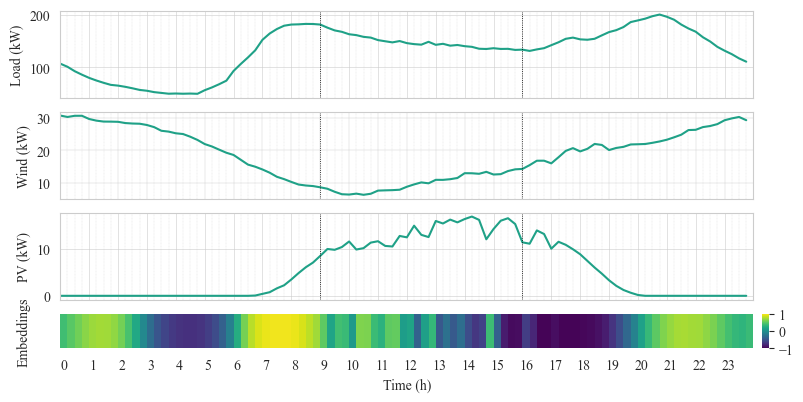

In [32]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.asset import map_to_range, np_to_torch, torch_to_np

sns.set_style('whitegrid')
colors = sns.color_palette("viridis_r", 6)

plt.rcParams['font.family'] = 'Times New Roman'

# Hook storage
intermediate_output = None
# Hook function to store intermediate activations
def hook_fn(module, input, output):
    global intermediate_output
    intermediate_output = output[0].detach()  # Store hidden states

# Register hook on LSTM layer
AttModel.attention.register_forward_hook(hook_fn)
DAY_PLT = 100

state,_ = env.reset(test=True, day=DAY_PLT)
input_data_np = state[0]

rewards = []
actions = []
done = False
while not done:
    # convert to tensor
    state_t = [np_to_torch(state[0]).to(device), np_to_torch(state[1]).to(device)]
    # select action
    # action_t, action_log_prob_t = AttModel.select_action(state_t[0], state_t[1], deterministic=True)
    action_t, action_log_prob_t = AttModel.select_action(state_t[0], state_t[1], deterministic=True)
    # convert to numpy
    action = torch_to_np(action_t)
    action_log_prob = torch_to_np(action_log_prob_t)
    # map action to range
    mapped_action = map_to_range(action, action_range)
    # take action
    next_state, reward, done, _, info = env.step(mapped_action)
    state = next_state
    rewards.append(reward)

battery_results = np.array(env.memory['storage'])

# Convert input data for visualization
output = action

# Plotting
minor_hours = np.arange(0, 24, 0.25)
major_hours = np.arange(0, 24, 1)

fig, axs = plt.subplots(4, 2, figsize=(8, 4), gridspec_kw={'height_ratios': [0.3, 0.3, 0.3, 0.12], 'width_ratios': [5, 0.05]})
axs = axs.flatten()
axs[1].set_visible(False)  # Hide empty subplot
axs[3].set_visible(False)  # Hide empty subplot
axs[5].set_visible(False)  # Hide empty subplot
# axs[7].set_visible(False)  # Hide empty subplot
# axs[9].set_visible(False)  # Hide empty subplot
# axs[11].set_visible(False)  # Hide empty subplot
# axs[13].set_visible(False)  # Hide empty subplot
# axs[15].set_visible(False)  # Hide empty subplot

# 🟢 First subplot: 96x3 input as three separate line plots

# self.normalize(add_uncertainty(day_data['load'],  self.t, base_noise_std=0.2), self.timeseries.min_load, self.timeseries.max_load)

axs[0].plot(np.arange(96)/4, dataset[DAY_PLT]["load"], label=f'Feature', color=colors[2])
# axs[0].legend()
axs[0].set_ylabel("Load (kW)")
axs[0].set_xticks(minor_hours, minor=True)
axs[0].set_xticks(major_hours, minor=False)
axs[0].set_xlim(0, 24)
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.2)
axs[0].grid(True, which='major', linestyle='-', linewidth=0.4)
axs[0].axvline(x = 9, color = 'black', linestyle=':', linewidth=0.6)
axs[0].axvline(x = 16, color = 'black', linestyle=':', linewidth=0.6)

axs[2].plot(np.arange(96)/4, dataset[DAY_PLT]["wind"], label=f'Feature', color=colors[2])
# axs[2].legend()
axs[2].set_ylabel("Wind (kW)")
axs[2].set_xticks(minor_hours, minor=True)
axs[2].set_xticks(major_hours, minor=False)
axs[2].set_xlim(0, 24)
axs[2].grid(True, which='minor', linestyle='--', linewidth=0.2)
axs[2].grid(True, which='major', linestyle='-', linewidth=0.3)
axs[2].axvline(x = 9, color = 'black', linestyle=':', linewidth=0.6)
axs[2].axvline(x = 16, color = 'black', linestyle=':', linewidth=0.6)

axs[4].plot(np.arange(96)/4, dataset[DAY_PLT]["solar"], label=f'Feature', color=colors[2])
# axs[4].legend()
axs[4].set_ylabel("PV (kW)")
axs[4].set_xticks(minor_hours, minor=True)
axs[4].set_xticks(major_hours, minor=False)
axs[4].set_xlim(0, 24)
axs[4].grid(True, which='minor', linestyle='--', linewidth=0.2)
axs[4].grid(True, which='major', linestyle='-', linewidth=0.4)
axs[4].axvline(x = 9, color = 'black', linestyle=':', linewidth=0.6)
axs[4].axvline(x = 16, color = 'black', linestyle=':', linewidth=0.6)

# for i in range(3):
#     axs[2*i].plot(np.arange(96)/4, input_data_np[:, i], label=f'Feature {i+1}', color=colors[1])
#     axs[2*i].legend()
#     axs[2*i].set_ylabel("Input")
#     axs[2*i].set_xticks(minor_hours, minor=True)
#     axs[2*i].set_xticks(major_hours, minor=False)
#     axs[2*i].set_xlim(0, 24)
#     axs[2*i].grid(True, which='minor', linestyle='--', linewidth=0.3)
#     axs[2*i].grid(True, which='major', linestyle='-', linewidth=1)


# 🔵 Second subplot: Heatmap of 96x1 output
signal_df = pd.DataFrame([np.array(intermediate_output.cpu().reshape(-1))], columns=(np.arange(96)/4).astype(int))
signal_df.index = [" "]

sns.heatmap(signal_df, cmap="viridis", cbar=True, ax=axs[6], cbar_ax=axs[7], xticklabels=4, vmin=-1, vmax=1)
axs[6].set_ylabel("Embeddings")
axs[6].set_xlabel("Time (h)")

# axs[2].set_xticks(np.arange(0,24.25,1))

# labels = ["Grid", 'Storage', 'FC', 'MT']
# for i in range(4, 8):
#     axs[2*i].plot(np.arange(96)/4, grid_results[:,i-4], label="Grid", color=colors[4])
#     # axs[2*i].set_xlabel("Time Step")
#     axs[2*i].set_ylabel(labels[i-4])
#     axs[2*i].set_xticks(minor_hours, minor=True)
#     axs[2*i].set_xticks(major_hours, minor=False)
#     axs[2*i].set_xlim(0, 24)

# Remove x-axis labels for all except the last subplot
for i in range(6):
    if i != 14:
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')

plt.tight_layout(pad=0.6)  # Reduce padding between subplots
plt.savefig('plots/embeddings.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


# SHAP

100%|██████████| 366/366 [02:14<00:00,  2.72it/s]


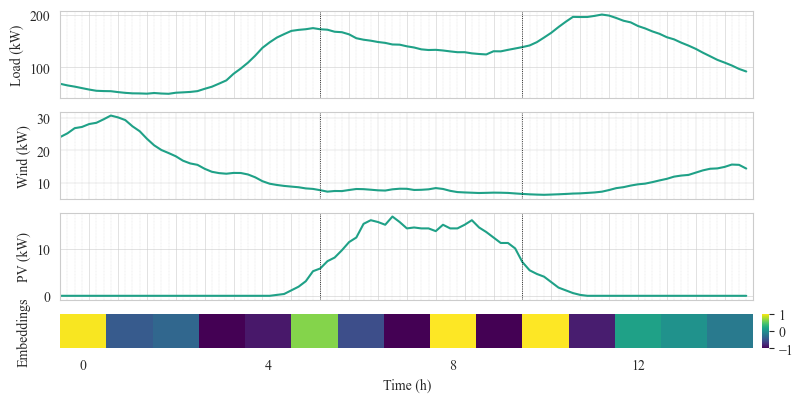

In [40]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.asset import map_to_range, np_to_torch, torch_to_np
from tqdm import tqdm

sns.set_style('whitegrid')
colors = sns.color_palette("viridis_r", 6)

plt.rcParams['font.family'] = 'Times New Roman'

# Hook storage
intermediate_input = None
# Hook function to store intermediate activations
def hook_fn(module, input, output):
    global intermediate_input
    intermediate_input = input[0].detach()  # Store hidden states

X_features = []
Y_predictions = []
# Register hook on LSTM layer
AttModel.fc_branch[0].register_forward_hook(hook_fn)


for NUM_DAY in tqdm(np.append(dataset.train, dataset.test)):
    state,_ = env.reset(test=True, day=NUM_DAY)
    input_data_np = state[0]

    rewards = []
    actions = []
    done = False
    while not done:
        # convert to tensor
        state_t = [np_to_torch(state[0]).to(device), np_to_torch(state[1]).to(device)]
        # select action
        # action_t, action_log_prob_t = AttModel.select_action(state_t[0], state_t[1], deterministic=True)
        action_t, action_log_prob_t = AttModel.select_action(state_t[0], state_t[1], deterministic=True)
        # convert to numpy
        action = torch_to_np(action_t)
        action_log_prob = torch_to_np(action_log_prob_t)
        # map action to range
        mapped_action = map_to_range(action, action_range)
        # take action
        next_state, reward, done, _, info = env.step(mapped_action)
        state = next_state
        rewards.append(reward)

        X_features.append(np.array(intermediate_input.cpu().reshape(-1)))
        Y_predictions.append(action)

X_features = np.array(X_features)
Y_predictions = np.array(Y_predictions)

# Convert input data for visualization
output = action

# Plotting
minor_hours = np.arange(0, 24, 0.25)
major_hours = np.arange(0, 24, 1)

fig, axs = plt.subplots(4, 2, figsize=(8, 4), gridspec_kw={'height_ratios': [0.3, 0.3, 0.3, 0.12], 'width_ratios': [5, 0.05]})
axs = axs.flatten()
axs[1].set_visible(False)  # Hide empty subplot
axs[3].set_visible(False)  # Hide empty subplot
axs[5].set_visible(False)  # Hide empty subplot

axs[0].plot(np.arange(96)/4, dataset[NUM_DAY]["load"], label=f'Feature', color=colors[2])
# axs[0].legend()
axs[0].set_ylabel("Load (kW)")
axs[0].set_xticks(minor_hours, minor=True)
axs[0].set_xticks(major_hours, minor=False)
axs[0].set_xlim(0, 24)
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.2)
axs[0].grid(True, which='major', linestyle='-', linewidth=0.4)
axs[0].axvline(x = 9, color = 'black', linestyle=':', linewidth=0.6)
axs[0].axvline(x = 16, color = 'black', linestyle=':', linewidth=0.6)

axs[2].plot(np.arange(96)/4, dataset[NUM_DAY]["wind"], label=f'Feature', color=colors[2])
# axs[2].legend()
axs[2].set_ylabel("Wind (kW)")
axs[2].set_xticks(minor_hours, minor=True)
axs[2].set_xticks(major_hours, minor=False)
axs[2].set_xlim(0, 24)
axs[2].grid(True, which='minor', linestyle='--', linewidth=0.2)
axs[2].grid(True, which='major', linestyle='-', linewidth=0.3)
axs[2].axvline(x = 9, color = 'black', linestyle=':', linewidth=0.6)
axs[2].axvline(x = 16, color = 'black', linestyle=':', linewidth=0.6)

axs[4].plot(np.arange(96)/4, dataset[NUM_DAY]["solar"], label=f'Feature', color=colors[2])
# axs[4].legend()
axs[4].set_ylabel("PV (kW)")
axs[4].set_xticks(minor_hours, minor=True)
axs[4].set_xticks(major_hours, minor=False)
axs[4].set_xlim(0, 24)
axs[4].grid(True, which='minor', linestyle='--', linewidth=0.2)
axs[4].grid(True, which='major', linestyle='-', linewidth=0.4)
axs[4].axvline(x = 9, color = 'black', linestyle=':', linewidth=0.6)
axs[4].axvline(x = 16, color = 'black', linestyle=':', linewidth=0.6)

# 🔵 Second subplot: Heatmap of 96x1 output
signal_df = pd.DataFrame([np.array(intermediate_input.cpu().reshape(-1))], columns=(np.arange(15)).astype(int))
signal_df.index = [" "]

sns.heatmap(signal_df, cmap="viridis", cbar=True, ax=axs[6], cbar_ax=axs[7], xticklabels=4, vmin=-1, vmax=1)
axs[6].set_ylabel("Embeddings")
axs[6].set_xlabel("Time (h)")

# Remove x-axis labels for all except the last subplot
for i in range(6):
    if i != 14:
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')

plt.tight_layout(pad=0.6)  # Reduce padding between subplots
plt.savefig('plots/features.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


In [41]:
np.random.seed(42)  
n_samples = X_features.shape[0]
random_indices = np.random.choice(n_samples, size=2000, replace=False)

X_features_sampled = X_features[random_indices]
Y_predictions_sampled = Y_predictions[random_indices]

In [42]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Your data (replace with your actual NumPy arrays)
N = len(X_features_sampled)  # Replace with your N
X = X_features_sampled  # Your N,15 features
y = Y_predictions_sampled   # Your N,3 predictions

# Define a new model using only fc_branch and fc_mean
class FCModel(nn.Module):
    def __init__(self, model):
        super(FCModel, self).__init__()
        self.fc_branch = model.fc_branch
        self.fc_mean = model.fc_mean

    def forward(self, x):
        x = self.fc_branch(x)
        x = self.fc_mean(x)
        return torch.tanh(x)

# Create the new model using the extracted layers
model = FCModel(AttModel).to(device)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# Predict with the new model
with torch.no_grad():
    y_pred_tensor = model(X_tensor)
    y_pred = y_pred_tensor.cpu().numpy()

# Compute Mean Absolute Error
print("Mean Absolute Error between given predictions and surrogate predictions:")
print(np.mean(np.abs(y - y_pred)))

# Create a SHAP explainer for the new model
def model_predict(X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        predictions = model(X_tensor)
        return predictions.cpu().numpy()
    
# Use a subset of the data as the background for SHAP
explainer = shap.DeepExplainer(model, X_tensor)

# Compute SHAP values
shap_values = explainer.shap_values(X_tensor, check_additivity=False)

Mean Absolute Error between given predictions and surrogate predictions:
8.344509e-08


SHAP Summary Plot for Output 0


C:\Users\HeydarianArdakaniA\AppData\Local\Temp\ipykernel_20696\2298249537.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


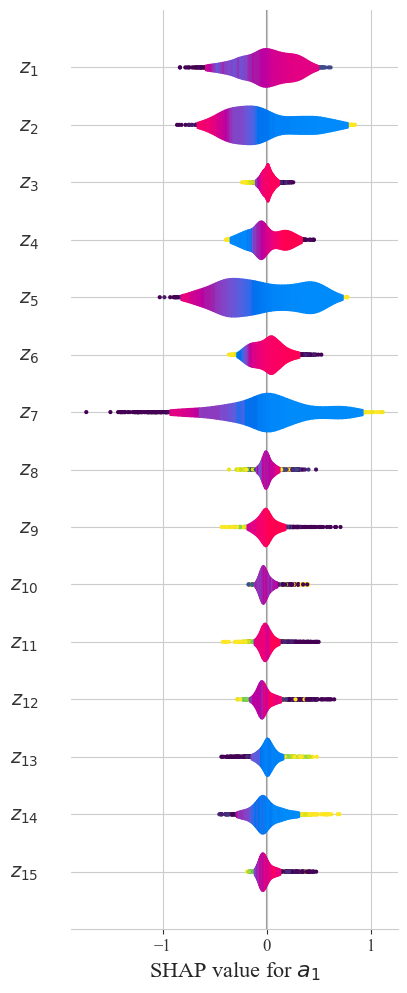

SHAP Summary Plot for Output 1


C:\Users\HeydarianArdakaniA\AppData\Local\Temp\ipykernel_20696\2298249537.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


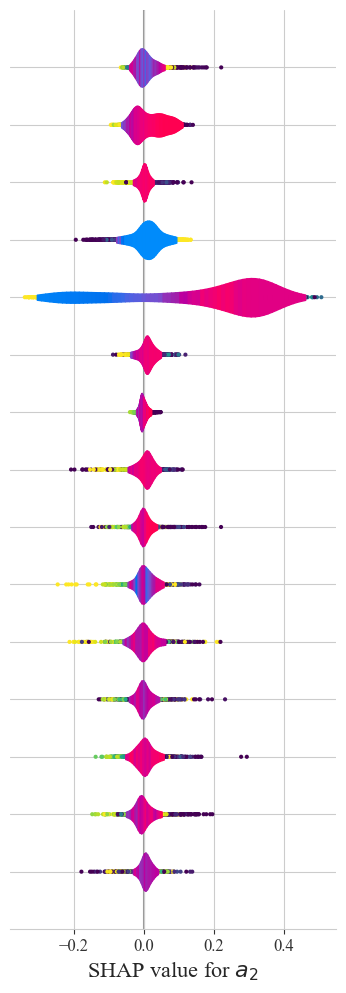

SHAP Summary Plot for Output 2


C:\Users\HeydarianArdakaniA\AppData\Local\Temp\ipykernel_20696\2298249537.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


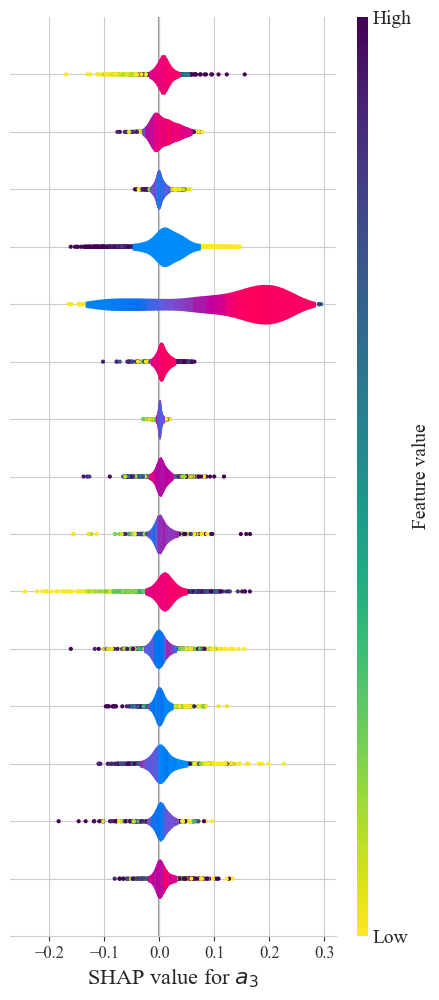

In [43]:
# Plot SHAP summary plot for each output
for i in range(3):
    print(f"SHAP Summary Plot for Output {i}")
    
    shap.summary_plot(
        shap_values[:,:,i], 
        X, 
        feature_names=[f"$z_{{{j+1}}}$" for j in range(15)], 
        show=False, 
        plot_type="violin", 
        cmap=plt.get_cmap('viridis_r'), 
        sort=False,
        plot_size=(5, 10),  # Width: 5 inches, Height: 10 inches
    )
    
    # Customize plot
    ax = plt.gca()
    
    # Set x-label to "SHAP Value" for all plots
    ax.set_xlabel(f"SHAP value for $a_{{{i+1}}}$", fontsize=16)
    ax.tick_params(axis='x', labelsize=12)    # X-tick font size
    ax.tick_params(axis='y', labelsize=14)    # Y-tick (feature names) font size

    # Only show y-labels for the first plot (i == 0)
    if i != 0:
        ax.set_ylabel("")  # Remove y-label for plots after the first one
        ax.set_yticklabels([])  # Remove y-tick labels
    
    # Remove color bar for all except the last plot
    if i < 2:
        cbar = plt.gcf().get_axes()[-1]  # Get the last axis (color bar)
        cbar.remove()  # Remove the color bar
    
    # Handle the color bar
    if i == 2: 
        cbar = plt.gcf().get_axes()[-1]
        cbar.tick_params(labelsize=14)  # Adjust color bar tick label size
        cbar.yaxis.label.set_size(14)

    # Save the plot with high DPI
    plt.savefig(f'plots/shap{i}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

# Correlation

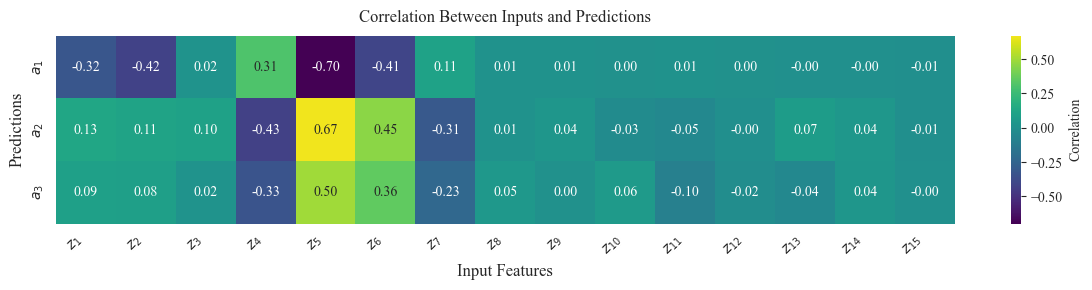

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the plotting backend is set correctly (optional, depending on your environment)

# Your data (replace with your actual NumPy arrays)
N = len(X_features)  # Replace with your N
X = X_features  # Your N,15 features
y = Y_predictions   # Your N,3 predictions

# Create column names for clarity
input_names = [f"$z_{{{j+1}}}$" for j in range(15)]
output_names = [f"$a_{{{i+1}}}$" for i in range(3)]

# Convert to pandas DataFrame
X_df = pd.DataFrame(X, columns=input_names)
y_df = pd.DataFrame(y, columns=output_names)

# Combine X and y into a single DataFrame
combined_df = pd.concat([X_df, y_df], axis=1)

# Compute the full correlation matrix
full_corr = combined_df.corr()

# Extract the 15x3 subset: correlations between inputs (rows) and predictions (columns)
correlation_matrix = full_corr.loc[input_names, output_names].values  # Shape: (15, 3)

# Create the heatmap (transposed: 3x15)
plt.figure(figsize=(12, 3))  # Adjust size as needed
heatmap = sns.heatmap(correlation_matrix.T,  # Shape: (3, 15)
                      annot=True,  # Show correlation values
                      cmap="viridis",  # Color scheme
                      center=0,  # Center the colormap at 0
                      xticklabels=input_names,  # Features on x-axis
                      yticklabels=output_names,  # Predictions on y-axis
                      fmt=".2f",  # Format numbers to 2 decimal places
                      annot_kws={"size": 10},  # Adjust font size of annotations
                      cbar_kws={"label": "Correlation"})  # Add label to colorbar

# Add labels and title
plt.title("Correlation Between Inputs and Predictions", fontsize=12, pad=10)
plt.xlabel("Input Features", fontsize=12)
plt.ylabel("Predictions", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Tight layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()